In [1]:
!pip install einops


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


Training normal classifier for CIFAR-10

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import torch, torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms
import os
import utils
from utils import compute_loss, compute_accuracy, plot_loss_and_accuracy, \
    plot_classes_preds

# a special module reshapes tensor from [batch, channel, w, h] to [batch, units]
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)

In [6]:
my_transform = {
    'train': transforms.Compose(
        [
            transforms.RandomCrop(32, padding=4),
            transforms.RandomHorizontalFlip(),
            transforms.RandomRotation(30),
            transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.05, hue=0.05),
            transforms.ToTensor(),
#             transforms.Normalize(mean=[0.485, 0.456, 0.406],
#                                  std=[0.229, 0.224, 0.225])
        ]),
    'test': transforms.Compose(
        [
            transforms.ToTensor(),
#               transforms.Normalize(mean=[0.485, 0.456, 0.406],
#                                    std=[0.229, 0.224, 0.225])
        ])
}

train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, 
                                             transform=my_transform['test'])
val_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, 
                                           transform=my_transform['test'])
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=my_transform['test'])

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Files already downloaded and verified


In [0]:
device = 'cuda:0'

In [0]:
class_names = ('airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

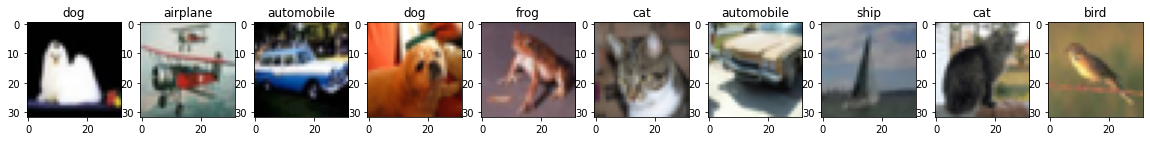

In [9]:
n_pics_to_show = 10
fig, ax = plt.subplots(1, n_pics_to_show, figsize=(20, 10))

for i in range(n_pics_to_show):
    rand_idx = np.random.randint(len(train_dataset))
    pic, label = train_dataset[rand_idx]
    
    pic_np = pic.data.numpy()
    pic_np = np.rollaxis(pic_np, 0, 3)    # 3xHxW to HxWx3
    ax[i].imshow(pic_np)
    ax[i].set_title(class_names[label])

In [0]:
def make_model():
    model = nn.Sequential(
        nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1),
        nn.BatchNorm2d(64),
        nn.ReLU(),
        nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
        nn.BatchNorm2d(128),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2),
        nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
        nn.BatchNorm2d(256),
        nn.ReLU(),
        nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
        nn.BatchNorm2d(256),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2),
        nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
        nn.BatchNorm2d(256),
        nn.ReLU(),
        nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
        nn.BatchNorm2d(256),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2),
        nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
        nn.BatchNorm2d(256),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2),
        Flatten(),
        nn.Linear(256 * (32 // 16) ** 2, 200),
        nn.BatchNorm1d(200),
        nn.ReLU(),
        nn.Linear(200, 10),
        nn.LogSoftmax(dim=1)
    )
    return model


In [0]:
batch_size = 150  # number of samples processed in one iteration
train_batch_gen = torch.utils.data.DataLoader(train_dataset, 
                                              batch_size=batch_size,
                                              shuffle=True,
                                              num_workers=4)

batch_size_val = 50
val_batch_gen = torch.utils.data.DataLoader(val_dataset, 
                                            batch_size=batch_size,
                                            shuffle=False,
                                            num_workers=1)

testloader = torch.utils.data.DataLoader(testset, batch_size=128,
                                         shuffle=False, num_workers=2)

In [0]:
import time
from datetime import datetime
from tqdm.notebook import tqdm
from torch.utils.tensorboard import SummaryWriter

device = 'cuda:0'

def train(model, num_epochs=50, lr=0.01, exp_name='my_network'):
    writer = SummaryWriter(f'logs/{exp_name}')
    opt = torch.optim.Adam(model.parameters(), lr=lr)

    train_loss = []
    train_accuracy = []
    val_accuracy = []

    for epoch in range(num_epochs):
        start_time = time.time()
        model.train(True) # enable dropout / batch_norm training behavior

        train_accuracy_batch = []

        for batch_no, (X_batch, y_batch) in tqdm(enumerate(train_batch_gen), 
                                                 total=len(train_batch_gen)):
            model.zero_grad()
            # transferring batch to GPU
            X_batch_gpu = X_batch.to(device)
            # forward propagation through the model
            logits = model(X_batch_gpu)
            # calculating loss
            loss = compute_loss(logits, y_batch, device=device)
            # backward propagation through the model
            loss.backward()
            # optimizer step
            opt.step()

            train_loss.append(loss.item())

            accuracy = compute_accuracy(logits, y_batch, device=device)
            train_accuracy_batch.append(accuracy.item())

            if batch_no % 15 == 0:
                plot_loss_and_accuracy(train_loss, train_accuracy, val_accuracy, clear_output=True)
                print(f'epoch {epoch} training stage...')
                
                # sending loss to TensorBoard (don't think about this for now)
                writer.add_scalar('training loss',
                                  loss.item(),
                                  len(train_loss))

        train_accuracy_overall = np.mean(train_accuracy_batch) * 100
        train_accuracy.append(train_accuracy_overall.item())

        print(f'epoch {epoch} testing stage...')
        model.train(False) # disable dropout / use averages for batch_norm
        val_accuracy_batch = []
        for X_batch, y_batch in tqdm(val_batch_gen):
            # transferring batch to GPU
            X_batch_gpu = X_batch.to(device)
            # forward propagation through the model
            logits = model(X_batch_gpu)

            # let's calculate the accuracy:
            accuracy = compute_accuracy(logits, y_batch, device=device)
            val_accuracy_batch.append(accuracy.item())
            
        # sending pictures to TensorBoard (don't think about this for now)
        writer.add_figure('predictions vs. actuals',
                          plot_classes_preds(model, X_batch_gpu, y_batch),
                          global_step=epoch)

        val_accuracy_overall = np.mean(val_accuracy_batch) * 100
        val_accuracy.append(val_accuracy_overall.item())

In [0]:
%load_ext tensorboard
logs_base_dir = "./logs"
os.makedirs(logs_base_dir, exist_ok=True)
%tensorboard --logdir {logs_base_dir}

In [0]:
model = make_model()
model = model.to(device)    # transferring model to GPU
exp_name = datetime.now().isoformat(timespec='seconds') +'_non_robust'
train(model, num_epochs=40, lr=0.001, exp_name=exp_name)
# to stop it press Ctrl+M I in Colab -- works better than "stop" button

In [0]:
!ls

In [0]:
torch.save(model.state_dict(), 'classifier_state_dict.pth')

In [0]:
from tqdm.notebook import tqdm

In [14]:
device='cpu'
model2 = make_model()
model2.load_state_dict(torch.load('/content/drive/My Drive/classifier_state_dict.pth', map_location=device))

<All keys matched successfully>

In [15]:
model2.to(device)
model2.eval()
val_accuracy_batch = []
for X_batch, y_batch in tqdm(val_batch_gen):
    # transferring batch to GPU
    X_batch_gpu = X_batch.to(device)
            # forward propagation through the model
    logits = model2(X_batch_gpu)

    # let's calculate the accuracy:
    accuracy = compute_accuracy(logits, y_batch, device=device)
    val_accuracy_batch.append(accuracy.item())

In [16]:
model2.train()

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): ReLU()
  (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (7): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (9): ReLU()
  (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (12): ReLU()
  (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): BatchNorm2d(256, eps=1e-05, momen

In [17]:
print('Accuracy on test set: {} %'.format(accuracy.cpu().numpy() * 100))

Accuracy on test set: 89.99999761581421 %


Creation of non-robust dataset

In [0]:
#criterion = nn.MSELoss()
criterion = nn.NLLLoss() 
lr = 0.1
eps = 0.5

In [0]:
batch_size = 1  # number of samples processed in one iteration
test_loader_shuffled = torch.utils.data.DataLoader(testset, 
                                              batch_size=batch_size,
                                              shuffle=True,
                                              num_workers=4)

test_loader = torch.utils.data.DataLoader(testset, 
                                            batch_size=batch_size,
                                            shuffle=False,
                                            num_workers=1)

In [0]:
model = model2

In [0]:
import random

class LinfPGDAttack:
  def __init__(self, model2, epsilon, num_steps, step_size):#, random_start):
    """Attack parameter initialization. The attack performs k steps of
       size a, while always staying within epsilon from the initial
       point."""
    self.model1 = make_model()
    self.model1.load_state_dict(torch.load('/content/drive/My Drive/classifier_state_dict.pth', map_location=device))
    self.model1.to(device)
    self.epsilon = epsilon
    self.num_steps = num_steps
    self.step_size = step_size
    #self.rand = random_start


    self.loss = nn.NLLLoss()


  def perturb(self, x_nat, y, labels, model1):
    """Given a set of examples (x_nat, y), returns a set of adversarial
       examples within epsilon of x_nat in l_infinity norm."""

    e = torch.tensor(np.random.uniform(-self.epsilon, self.epsilon, x_nat.shape)) # ensure valid pixel range     
    x_gpu = x_nat.to(device)
    
    model1.eval()
    #t = torch.randint(0, 10, (1,)).to(device)
    #t = torch.tensor(1).reshape(1,).to(device)
    t=(y+1)%10
    y=torch.tensor(y).reshape(1,)
    t = torch.tensor(t).reshape(1,).to(device)
    for i in range(self.num_steps):

      x_gpu.requires_grad=True
      o = model2(x_gpu)
      #loss = nn.NLLLoss()(o, t)
      loss = compute_loss(o, t, device=device)
      grad=torch.autograd.grad(loss, x_gpu,retain_graph=True)

      x_gpu.requires_grad=False
      x = x_gpu.clone().detach().cpu().numpy()
      x = np.add(x, self.step_size* np.sign(grad[0].detach().cpu().numpy()))#, casting='unsafe')
      x = np.clip(x, x_nat.detach().cpu().numpy() - self.epsilon, x_nat.detach().cpu().numpy() + self.epsilon)
      x = np.clip(x, 0, 255)
      x_gpu = torch.tensor(x).float().to(device)

    return x_gpu, t

In [0]:
eps = 0.02
num_steps = 50
step_size = 0.01
attack = LinfPGDAttack(model2 , eps, num_steps, step_size)

NameError: ignored

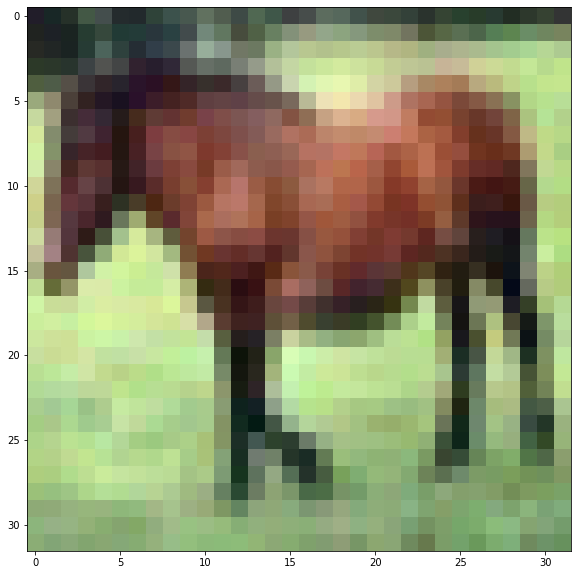

In [24]:
labels = [0,1,2,3,4,5,6,7,8,9]
fig, ax = plt.subplots(1, 1, figsize=(20, 10))
x, y = train_dataset[7]
x=x.reshape(1,3,32,32)
X, t = attack.perturb(x, y, labels, model2.to(device))
pic_np = X.detach().cpu().numpy().reshape(3, 32,32)
pic_np = np.rollaxis(pic_np, 0, 3)    # 3xHxW to HxWx3
ax.imshow(pic_np)
#title = class_names[y] + '+' + class_names[t.item()]
ax.set_title(title)

In [0]:
logits = model2(x.to(device))
class_names[logits.argmax().item()]

In [0]:
logits = model2(X) 
class_names[(logits).argmax().item()]

In [0]:
device = 'cuda:0'
batch_size = 1  # number of samples processed in one iteration
train_batch_gen = torch.utils.data.DataLoader(train_dataset, 
                                              batch_size=batch_size,
                                              shuffle=True,
                                              num_workers=4)

batch_size_val = 1
val_batch_gen = torch.utils.data.DataLoader(val_dataset, 
                                            batch_size=batch_size,
                                            shuffle=False,
                                            num_workers=1)

testloader = torch.utils.data.DataLoader(testset, batch_size=1,
                                         shuffle=False, num_workers=2)
def data_gen():
  ours_adversarial_rand_det = []
  i=0
  for(X_batch, y_batch) in tqdm(train_batch_gen):##train_batch_gen):
    y_robust =  y_batch.clone()        
    X_batch, y_batch = attack.perturb(X_batch, y_batch, labels, model2.to(device))

    y_batch=y_batch.cpu()
    ours_adversarial_rand_det.append([X_batch, y_robust, y_batch])
    if i%1000 ==0:
      torch.save(ours_adversarial_rand_det, '/content/drive/My Drive/DED.pt')
    if i == 10003:
      break
    i=i+1
  torch.save(ours_adversarial_rand_det, '/content/drive/My Drive/DED.pt')
data_gen()  

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


In [0]:
ours_adversarial_test = torch.load('/content/drive/My Drive/AA.pt')

In [0]:
model2.to(device)
non_robust_ds = []
crit = nn.MSELoss()
for i, (X_batch, y_batch) in tqdm(enumerate(test_loader)):
    
    X_rand_batch, _ = next(iter(test_loader_shuffled))

    X_batch_gpu = X_batch.to(device)
    #print(X_batch.numpy().shape)
    a = torch.tensor(np.random.rand(3*32*32))
    X_rand_batch_gpu = a.reshape(1,3,32,32)
    #print(X_rand_batch_gpu.shape)
    X_rand_batch_gpu.requires_grad=True
    X_rand_batch_gpu=X_rand_batch_gpu.float().to(device)
    

    #x_gpu = X_rand_batch_gpu.clone()
    #x_pred_gpu = x_gpu.clone()
    logits_true = model2(X_batch_gpu)
    logits_true = logits_true.detach()
    #print('bum')
    for _ in range(100):
        #print('pum')
        X_rand_batch_gpu.requires_grad_(True)
        logits = model2(X_rand_batch_gpu)
        l = crit(logits, logits_true)
        #loss = criterion(logits, t)
        #l.backward(retain_graph=True)

        grad = torch.autograd.grad(l, X_rand_batch_gpu)
        x = X_rand_batch_gpu.detach().cpu().numpy()
        x = np.add(x, -lr*grad[0].detach().cpu().numpy())#, casting='unsafe')
        x = np.clip(x, X_batch_gpu.detach().cpu().numpy() - eps, X_batch_gpu.detach().cpu().numpy() + eps)
        x = np.clip(x, 0, 1) # ensure valid pixel range
        X_rand_batch_gpu = torch.tensor(x).to(device)

        #if torch.norm(x_gpu - x_pred_gpu) < 10**(-3):
        X_rand_batch_gpu.requires_grad_(True)
        #l.zero_grads()

    non_robust_ds.append([X_rand_batch_gpu.cpu().detach().numpy(), y_batch.item()])

In [0]:
non_robust_ds

In [0]:
with open('non_robust_ds_2.txt', 'w') as f:
    f.write(non_robust_ds[0][0].cpu().detach().numpy())

In [0]:
torch.save(non_robust_ds, '/content/drive/My Drive/non_r_dst.pt') 

In [0]:
#a = torch.load('file.pt')

In [0]:
n_pics_to_show = 10
fig, ax = plt.subplots(2, n_pics_to_show, figsize=(20, 10))

for i in range(n_pics_to_show):
    rand_idx = np.random.randint(len(non_robust_ds))

    pic = non_robust_ds[rand_idx][0][0]
    label = non_robust_ds[rand_idx][1]
    pic2, label2 = val_dataset[rand_idx]

    pic_np = pic#.cpu().data.numpy()
    pic_np = np.rollaxis(pic_np, 0, 3)    # 3xHxW to HxWx3

    pic_np2 = pic2.cpu().data.numpy()
    pic_np2 = np.rollaxis(pic_np2, 0, 3)    # 3xHxW to HxWx3

    ax[0, i].imshow(pic_np)
    ax[0, i].set_title(class_names[label])

    ax[1, i].imshow(pic_np2)
    ax[1, i].set_title(class_names[label2])

Evaluation of non-robust dataset on same model trained on normal dataset (should be relatively low)

In [0]:
Nr = []
for item in nr:
    Nr.append([item[0].cpu().detach().requires_grad_(False).reshape(3, 32, 32), item[1].cpu()[0].item()])

In [0]:
batch_size = 100  # number of samples processed in one iteration
nr_batch_gen = torch.utils.data.DataLoader(Nr, 
                                              batch_size=batch_size,
                                              shuffle=True,
                                              num_workers=4)

In [0]:
model2.to(device)
model2.eval()
val_accuracy_batch = []
for X_batch, y_batch in tqdm(nr_batch_gen):
    # transferring batch to GPU
    X_batch_gpu = X_batch.to(device)
            # forward propagation through the model
    logits = model2(X_batch_gpu)

    # let's calculate the accuracy:
    accuracy = compute_accuracy(logits, y_batch, device=device)
    val_accuracy_batch.append(accuracy.item())

In [0]:
print('Accuracy on test set: {} %'.format(accuracy.cpu().numpy() * 100))

Evaluation on already robust net

In [0]:
!pip install robustness

In [0]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from robustness.model_utils import make_and_restore_model
from robustness.datasets import CIFAR
from tqdm.notebook import tqdm
import utils

from utils import compute_accuracy

In [0]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [0]:
nr = torch.load('nr_1.pt')

In [0]:
Nr = []
for item in nr:
    Nr.append([item[0].cpu().detach().requires_grad_(False).reshape(3, 32, 32), item[1].cpu()[0].item()])

batch_size = 2  # number of samples processed in one iteration
nr_batch_gen = torch.utils.data.DataLoader(Nr, 
                                              batch_size=batch_size,
                                              shuffle=False,
                                              num_workers=4)

In [0]:
ds = CIFAR('data') 
device = 'cuda:0'
model, _ = make_and_restore_model(arch='resnet50', dataset = ds)
model.eval()
model.to(device)

In [0]:
val_accuracy_batch = []
for X_batch, y_batch in tqdm(nr_batch_gen):
    # transferring batch to GPU
    X_batch_gpu = X_batch.to(device)
            # forward propagation through the model
    logits = model(X_batch_gpu)[0]
    #logits = torch.tensor(logits)
    # let's calculate the accuracy:
    accuracy = compute_accuracy(logits, y_batch, device=device)
    val_accuracy_batch.append(accuracy.item())

In [0]:
print('Accuracy on test set: {} %'.format(np.mean(val_accuracy_batch)))

Evaluation of robust dataset on normal model

In [0]:
r = torch.load('file (1).pt')

In [0]:
R = []
idx = 0
for item in r:
    R.append([item[0].detach().requires_grad_(False), train_dataset[idx][1]])
    idx += 1

In [0]:
batch_size = 2  # number of samples processed in one iteration
r_batch_gen = torch.utils.data.DataLoader(R, 
                                           batch_size=batch_size,
                                           shuffle=False)

In [0]:
model2 = make_model()
model2.load_state_dict(torch.load('classifier_state_dict.pth', map_location=device))

model2.to(device)
model2.eval()

In [0]:
val_accuracy_batch = []
for X_batch, y_batch in tqdm(r_batch_gen):
    # transferring batch to GPU
    X_batch_gpu = X_batch.to(device)
            # forward propagation through the model
    logits = model2(X_batch_gpu)

    # let's calculate the accuracy:
    accuracy = compute_accuracy(logits, y_batch, device=device)
    val_accuracy_batch.append(accuracy.item())

In [0]:
print('Accuracy on test set: {} %'.format(np.mean(val_accuracy_batch)))